In [1]:
!pip install gif

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Created wheel for gif: filename=gif-3.0.0-py3-none-any.whl size=4816 sha256=f076beb95dbccf174a7f0f5d25a2d0f27201b75df2072540e6c600176b2d5d0d
  Stored in directory: /tmp/pip-ephem-wheel-cache-vqppy6az/wheels/d8/db/4e/e0ce5209665322902834f4e88fa987f4dfa0c08271368ef098
Successfully built gif


In [2]:
import numpy as np
import os
os.chdir("/notebooks")
import matplotlib.pyplot as plt
import gif
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from pytorch_lightning import LightningModule
import torch
import torch.nn as nn
import math
from base_lightning import Dataset
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.animation import FuncAnimation
from sklearn.linear_model import LassoCV,Lasso

from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import LearningRateMonitor,TQDMProgressBar,EarlyStopping


def gpu_prints():
    print("The total number of GPUs is:",torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print("GPU number",i,"is",torch.cuda.get_device_name(i))
        
gpu_prints()
now = datetime.now()
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")

/tmp/ipykernel_1209/4283117880.py:6: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


The total number of GPUs is: 1
GPU number 0 is Quadro P5000


In [3]:
class SinusoidalActivation(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.pi = torch.tensor([math.pi],dtype=torch.float32)
    
    def forward(self,input): 
        
        sinusoid = torch.sin(2*self.pi*input)
        return sinusoid

class NN(nn.Module):
    
    def __init__(self,hidden,init=False):
        
        super().__init__()
        self.init = init
        self.network = self.build_network(hidden,sigma=1)
        
    def forward(self, input_: torch.Tensor):
        
        input_ = input_.requires_grad_(True)
        return self.network(input_),input_

    def build_network(self,hidden,sigma):

        network= []
        first = nn.Linear(2,hidden)
        if self.init:
            print("Initing NN weights and baises")
            nn.init.normal_(first.weight,0,sigma**2)
            nn.init.zeros_(first.bias)
        network.append(first)
        network.append(SinusoidalActivation())
        
        second = nn.Linear(hidden,hidden)
        if self.init:
            torch.nn.init.xavier_uniform_(second.weight)
            torch.nn.init.zeros_(second.bias)
        network.append(second)
        network.append(nn.Tanh())
        
        third = nn.Linear(hidden,hidden)
        if self.init:
            torch.nn.init.xavier_uniform_(third.weight)
            torch.nn.init.zeros_(third.bias)
        network.append(third)
        network.append(nn.Tanh())
        
        fourth = nn.Linear(hidden,hidden)
        if self.init:
            torch.nn.init.xavier_uniform_(fourth.weight)
            torch.nn.init.zeros_(fourth.bias)
        network.append(fourth)
        network.append(nn.Tanh())
        
        fith = nn.Linear(hidden,hidden)
        if self.init:
            torch.nn.init.xavier_uniform_(fith.weight)
            torch.nn.init.zeros_(fith.bias)
        network.append(fith)
        network.append(nn.Tanh())
        
        sixth = nn.Linear(hidden,1)
        if self.init:
            torch.nn.init.xavier_uniform_(sixth.weight)
            torch.nn.init.zeros_(sixth.bias)
        network.append(sixth)
        network.append(nn.Tanh())
        
        network.pop()
        network = nn.Sequential(*network)
        
        return network 

In [4]:
class PINN(LightningModule):

    def __init__(self,filename,config):

        super().__init__()
        
        self.data            = np.load(filename)
        a = filename.split('/')
        self.dir = a[0]
        self.filename = a[-1].split('.npz')[0]
        
        self.c               = torch.tensor(self.data["c"],dtype=torch.float32)
        self.v               = torch.tensor(self.data["v"],dtype=torch.float32)
        self.first_coeff  = -(self.c**2-self.v**2)
        self.second_coeff = +2*self.v
        self.total_x         = torch.tensor(self.data["X"],dtype=torch.float32)
        self.T               = torch.tensor(self.data["t"],dtype=torch.float32)
        self.T               = self.T[self.T<=4]
        
        self.U               = np.array(self.data["wave"])
        self.U               = self.U[:self.T.shape[0]]
        self.coefs           = self.data["coefs"]

        
        self.initial_xi         = None
        self.lr                 = config["lr"]
        self.k_pde              = config["k_pde"]
        self.k_mse              = config["k_mse"]
        self.network            = NN(init=False,hidden=50)
        
        
         
        self.total_X         = torch.tensor(self.data["total_X"],dtype=torch.float32)
        self.total_X         = self.total_X[self.total_X[:,0]<=4]
        self.total_Y         = torch.tensor(self.data["total_Y"],dtype=torch.float32)
        self.total_Y         = self.total_Y[:self.total_X.shape[0]]

        
        self.X1              = self.total_X[self.total_X[:,0]<=2]
        self.Y1              = self.total_Y[self.total_X[:,0]<=2]
 
        
       

        
        self.X_validation    = self.total_X[self.total_X[:,0]>=2]
        self.Y_validation    = self.total_Y[self.X_validation.shape[0]:]
        
        self.X_fixed_points  = self.X_validation[(self.X_validation[:,1]== 0)  |
                                                 (self.X_validation[:,1]== 0.1)|
                                                 #(self.X_validation[:,1]== 0.2)|
                                                 #(self.X_validation[:,1]== 0.3)|
                                                 #(self.X_validation[:,1]== 0.4)|
                                                 #(self.X_validation[:,1]== 0.5)|
                                                 #(self.X_validation[:,1]== 0.6)|
                                                 #(self.X_validation[:,1]== 0.7)|
                                                 #(self.X_validation[:,1]== 0.8)|
                                                 (self.X_validation[:,1]== 0.9)|
                                                 (self.X_validation[:,1]== 1)
                                                ]
        
        self.Y_fixed_points  = self.Y_validation[(self.X_validation[:,1]== 0) |
                                                 (self.X_validation[:,1]== 0.1)|
                                                 #(self.X_validation[:,1]== 0.2)|
                                                 #(self.X_validation[:,1]== 0.3)|
                                                 #(self.X_validation[:,1]== 0.4)|
                                                 #(self.X_validation[:,1]== 0.5)|
                                                 #(self.X_validation[:,1]== 0.6)|
                                                 #(self.X_validation[:,1]== 0.7)|
                                                 #(self.X_validation[:,1]== 0.8)|
                                                 (self.X_validation[:,1]== 0.9)|
                                                 (self.X_validation[:,1]== 1)
                                                 ]
        
        
        
        self.X_MSE           = self.X_fixed_points
        self.Y_MSE           = self.Y_fixed_points
        
    
        print("1st coef:",self.first_coeff)
        print("2nd coef:",self.second_coeff)

        
    def fig2img(self,fig):
        """Convert a Matplotlib figure to a PIL Image and return it"""
        buf = io.BytesIO()
        fig.savefig(buf)
        buf.seek(0)
        img = Image.open(buf)
        return img
        
    def forward(self,input_):
                
        return self.network(input_)
    
    def on_fit_start(self):      
        
        self.initial_xi = [1,1]
        aux1,aux2 = self.forward(self.X1.to(device='cuda:0'))
        second_time_deriv,theta,term1,term2 = self.compute_derivatives(aux1,aux2)
        self.initial_xi = self.least_squares_QR(theta,second_time_deriv).detach()
        print(self.initial_xi)
        
        fig,ax1 = plt.subplots(figsize=(20,7))
        extent = np.min(self.total_x.detach().cpu().numpy()), np.max(self.total_x.detach().cpu().numpy()), np.min(self.T.detach().cpu().numpy()), np.max(self.T.detach().cpu().numpy())
        im1 = plt.imshow(self.U,origin="lower",cmap=plt.cm.magma,extent=extent,aspect="auto",interpolation=None)
        plt.colorbar()
        plt.xlabel("X")
        plt.ylabel("Time")
        plt.title(f"Real wave")
        image=self.fig2img(fig)
        self.logger.experiment.log_image(image,name="Real Wave")     
        self.anim()

    def training_step(self, batch,batch_idx):
        
        #forward pass
        batch1 = batch["mse"]
        batch2 = batch["pde"]

        x1,target1 = batch1
        x2,target2 = batch2

        prediction1,coordinates1 = self.forward(x1)
        prediction2,coordinates2 = self.forward(x2)

        second_time_deriv,theta,term1,term2 = self.compute_derivatives(prediction2,coordinates2)
        self.xi = self.least_squares_QR(theta,second_time_deriv)
        
        #losses
        mse_loss                            = torch.mean((prediction1-target1)**2) # scalar
        pde_loss                            = torch.mean((second_time_deriv-(term1+term2))**2)#should be scalar as well
        total_loss                          = self.k_mse*mse_loss  + self.k_pde*pde_loss


        self.log(f"Coefficient nr1",self.xi[0],logger=True,on_epoch=True,on_step=False)
        self.log(f"Coefficient nr2",self.xi[1],logger=True,on_epoch=True,on_step=False)
        self.log(f"Error in coefficient nr1",torch.abs((self.xi[0]-self.first_coeff)/self.first_coeff)*100,logger=True,on_epoch=True,on_step=False)
        self.log(f"Error in coefficient nr2",torch.abs((self.xi[1]-self.second_coeff)/self.second_coeff)*100,logger=True,on_epoch=True,on_step=False)
    
        self.log("MSE Loss",mse_loss,on_step=False,on_epoch=True,logger=True,prog_bar=True)
        self.log("PDE Loss",pde_loss,on_step=False,on_epoch=True,logger=True,prog_bar=True)
        self.log("Total Loss",total_loss,on_step=False,on_epoch=True,logger=True,prog_bar=True)      
        
        return total_loss

    def validation_step(self,batch,batch_idx):

        x,target = batch
        val_prediction,val_coordinates = self.forward(x)
        val_loss = torch.mean((val_prediction-target)**2)
        self.log("Validation Loss",val_loss,on_step=False,on_epoch=True,logger=True,prog_bar=True)


    def compute_derivatives(self,prediction,coords,derivs=False):
        
        du = grad(outputs=prediction, inputs=coords, grad_outputs=torch.ones_like(prediction), create_graph=True)[0]
        first_time_deriv = du[:,0:1]
        du_dx            = du[:,1:2]

        du2 = grad(outputs=first_time_deriv,inputs=coords,grad_outputs=torch.ones_like(prediction),create_graph=True)[0]
        second_time_deriv = du2[:,0:1]
        du2_dtdx          = du2[:,1:2]

        du2_dx2 = grad(outputs=du_dx,inputs=coords,grad_outputs=torch.ones_like(prediction),create_graph=True)[0][:,1:2]

        term1 = self.initial_xi[0]*du2_dx2
        term2 = self.initial_xi[1]*du2_dtdx

        theta = torch.reshape(torch.cat((term1,term2),dim=1),(prediction.shape[0],-1))

        if not derivs:

            return second_time_deriv,theta,term1,term2

        else:

            return second_time_deriv,du2_dtdx,du2_dx2


        
    def least_squares_QR(self,theta,second_deriv):

        Q,R = torch.linalg.qr(theta)
        xi  = torch.inverse(R) @ Q.T @ second_deriv
        return xi
    
    def configure_optimizers(self):

        optimizer = torch.optim.AdamW(self.parameters(),lr=self.lr,amsgrad=True,weight_decay=1e-8)

        return optimizer

    def train_dataloader(self):

        dataset1   = Dataset(data=self.X_MSE, labels=self.Y_MSE)
        dataset2   = Dataset(data=self.X_validation,labels = self.Y_validation)

        dataloader1 = torch.utils.data.DataLoader(dataset1, batch_size=int(self.X_MSE.shape[0]/4),drop_last=True, shuffle=True,num_workers=0)
        dataloader2 = torch.utils.data.DataLoader(dataset2, batch_size=int(self.X_validation.shape[0]/4),drop_last=True,shuffle=True,num_workers=0)



        return {"mse":dataloader1,"pde":dataloader2}

    def val_dataloader(self):

        val_dataset = Dataset(data=self.X_validation, labels=self.Y_validation)
        val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=int(self.X_validation.shape[0]/4),
                                                     drop_last=True, num_workers=0, shuffle=False)

        return val_dataloader

    def plot(self):

        
        total_output = self.forward(self.total_X.to(self.device))[0].detach().cpu().numpy().reshape(self.T.shape[0],self.total_x.shape[0])
        fig,ax1 = plt.subplots(figsize=(20,7))
        extent = np.min(self.total_x.detach().cpu().numpy()), np.max(self.total_x.detach().cpu().numpy()), np.min(self.T.detach().cpu().numpy()), np.max(self.T.detach().cpu().numpy())
        im1 = plt.imshow(total_output,origin="lower",cmap=plt.cm.magma,extent=extent,aspect="auto",interpolation=None)
        plt.colorbar()
        plt.xlabel("X")
        plt.ylabel("Time")
        image = self.fig2img(fig)
        self.logger.experiment.log_image(image,name=f"Full predicted wave")
        plt.close()
        
        
        fig,ax1 = plt.subplots(figsize=(20,7))
        extent = np.min(self.total_x.detach().cpu().numpy()), np.max(self.total_x.detach().cpu().numpy()), np.min(self.T.detach().cpu().numpy()), np.max(self.T.detach().cpu().numpy())
        im1 = plt.imshow(np.abs(total_output-self.U),origin="lower",cmap=plt.cm.magma,extent=extent,aspect="auto",interpolation=None)
        plt.colorbar()
        plt.xlabel("X")
        plt.ylabel("Time")
        plt.title(f"Difference between true wave and predicted wave at epoch {self.current_epoch}")
        image = self.fig2img(fig)
        self.logger.experiment.log_image(image,name=f"Difference between true wave and predicted wave")
        plt.close()
    
    def anim(self):
        
        def init():
            for line in lines:
                line.set_data([],[])
            return lines

        fig = plt.figure(figsize=(15,5))
        ax = plt.axes(xlim=(0,1),ylim=(-3,3))
        line, = ax.plot([], [], lw=3)
        plt.xlim(0,1)
        plt.ylim(-3,3)
        plt.xlabel("X")
        plt.ylabel("Displacement")
        plt.title(f"Prediction for epoch {self.current_epoch}",fontsize=20)
        lines = []
        lobj1 = ax.plot([],[],lw=3,label="Predicted")[0]
        lobj2 = ax.plot([],[],lw=3,label="Real")[0]
        lines.append(lobj1)
        lines.append(lobj2)
        plt.legend()
        
        
        anim = FuncAnimation(fig,
                    self.update_plot,
                    init_func=init,
                    frames=int(len(self.T)),
                    fargs=(lines),
                     blit=True,
                    interval=100,
                    repeat=True)
        
        plt.legend()
        writergif = animation.PillowWriter(fps=30)

        anim.save(f"predictions/{self.filename}_epoch{self.current_epoch}_{now.minute}{now.second}" + ".gif",writer="ffmpeg")
        plt.close()
        self.logger.experiment.log_image(f"predictions/{self.filename}_epoch{self.current_epoch}_{now.minute}{now.second}" + ".gif",name=f"Prediction gif at {self.current_epoch}")
    
    def update_plot(self,i,line1,line2):
        
        a = self.forward(self.total_X.to(self.device))[0].detach().cpu().numpy()
        b   = a.reshape(self.T.shape[0],self.total_x.shape[0])
        line1.set_data(self.total_x,b[i,:])
        line2.set_data(self.total_x,self.U[i,:])
        lines = (line1,line2)
        
        return lines    
    
    def on_validation_epoch_end(self):
        
        self.plot()
        self.anim()
    
        

In [5]:
filename =  "resolution/data/spatial/c=1_v=0.5c_noise=0.0_modes=0.08_0.49_0.85_0.35_0.15_dt=0.010_dx=0.002.npz"
model_path = "noise/models/PINNs/REGULAR_NN_c=1_v=0.5c_noise=0.0_modes=0.08_0.49_0.85_0.35_0.15_dt=0.010_dx=0.002_16002k.ckpt"

config = {
        "lr": 1e-3,
        "filename":filename,
        "k_pde":1e-4,
        "k_mse":10,
        "PATH":model_path
    } 

model = PINN.load_from_checkpoint(checkpoint_path=model_path,filename=filename,config=config)


1st coef: tensor(-0.7500)
2nd coef: tensor(1.)


(400,)
(501,)


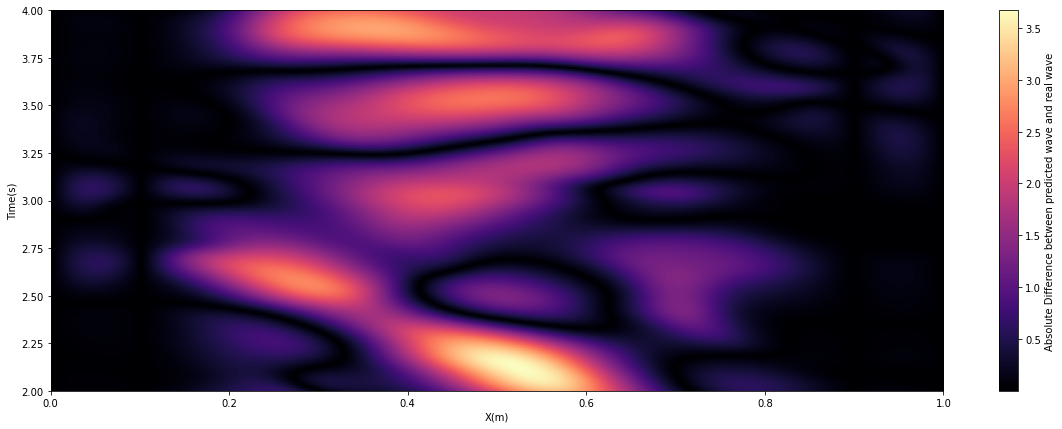

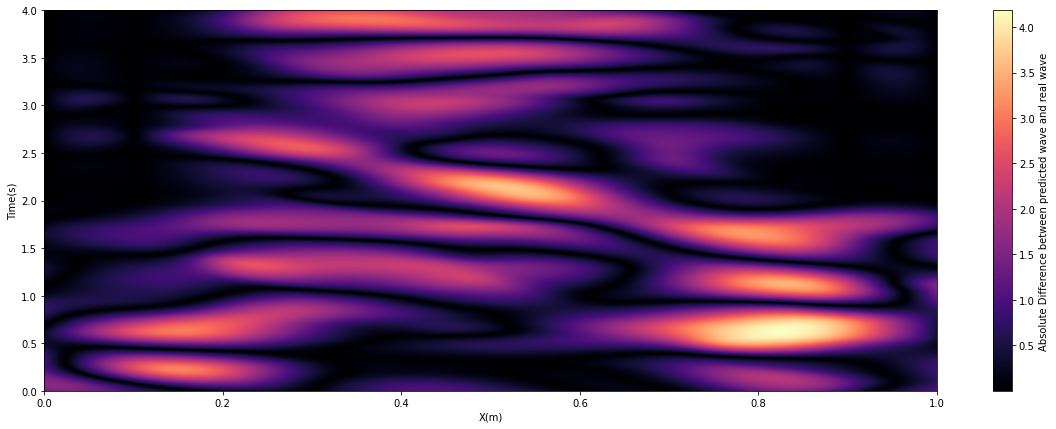

In [10]:
data = np.load(filename)
t = data["t"]
t = t[t<=4]
print(t.shape)
x = data["X"]
print(x.shape)
true_wave = data["wave"]

train = data["X_train"]
validation = data["X_validation"]
total_input = torch.tensor(data["total_X"],dtype=torch.float32)
total_input = total_input[total_input[:,0]<=4]

data_array = model.forward(total_input.to("cpu"))[0].detach().cpu().numpy()
data_array = data_array.reshape(t.shape[0],x.shape[0])


real_wave              = np.array(data["wave"])
real_wave              = real_wave[:t.shape[0]]

diff = np.abs(data_array-real_wave)
half_diff = diff[int(diff.shape[0]/2):,:]


fig,ax1 = plt.subplots(figsize=(20,7))

extent = [0,1,2,4]
im1 = plt.imshow(half_diff,origin="lower",cmap=plt.cm.magma,extent=extent,aspect="auto",interpolation=None)
plt.colorbar(im1,label="Absolute Difference between predicted wave and real wave")
plt.xlabel("X(m)")
plt.ylabel("Time(s)")
plt.savefig("Noise_error_zoom.png",format="png",bbox_inches="tight")
plt.show()


fig,ax1 = plt.subplots(figsize=(20,7))
extent = [0,1,0,4]
im1 = plt.imshow(diff,origin="lower",cmap=plt.cm.magma,extent=extent,aspect="auto",interpolation=None)
plt.colorbar(im1,label="Absolute Difference between predicted wave and real wave")
plt.xlabel("X(m)")
plt.ylabel("Time(s)")
plt.savefig("regularNN_diff.png",format="png",bbox_inches="tight")
plt.show()

In [8]:
from matplotlib.offsetbox import AnchoredText

@gif.frame
def helper_plot(data_array,real_wave,x,i):
    sep  = int(data_array.shape[0]/2)
    data = data_array.copy()
    fig,ax = plt.subplots(figsize=(15,10))
    
    if i < sep:
        color1 = "orange"
        color2 = "red"
        label1 = "Model prediction"
        label2 = "Ground truth"
        marker = "x"
        alpha2 = 0.5
        at2    = AnchoredText(f"Training t<2s", prop=dict(size=15), frameon=True, loc='upper center')
        order  = [0,1]

    
    if i >= sep:
        
        color1 = "orange"
        label1 = "Model prediction"
        at2    = AnchoredText(f"Extrapolating t>2s ", prop=dict(size=15), frameon=True, loc='upper center')
        alpha2 = 1
        color2 = "blue"
        label2 = "Ground truth test data"
        marker = None
        
        
        
        plt.plot([0],[0],marker="x",color="red",markersize=12,label="Ground truth training data")
        plt.plot([1],[0],marker="x",markersize=12,color="red")
        order  = [0,2,1]
        
        
        
    #TIME elapsing annotation
    at = AnchoredText(f"t={i/100}s", prop=dict(size=15), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    
    at2.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at2)
    
    #real plots
    
    plt.plot(x,data[i,:],color=color1,linestyle="solid",lw=4,label = label1)
    plt.plot(x,real_wave[i,:],color=color2,linestyle="dashed",lw=3,label=label2,marker=marker,markersize=12,alpha=alpha2)
    
    
   
    
    #plt.vlines(x=0,color="r",ymin=-3,ymax=3,lw=4,label="Fixed points")
    #plt.vlines(x=1,color="red",linestyles="dashed",ymin=-3,ymax=3,lw=2)
    
    #plot settings
    plt.plot(0,0)
    plt.xlim(-0.1,1.1)
    plt.ylim(np.min(data),np.max(data))
    plt.xlabel("X")
    plt.ylabel("Displacement")
    
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize=20)

    
    
    plt.grid()
    plt.title(f"Vibrating String with horizontal speed")
    

In [9]:
from functools import wraps
from io import BytesIO as Buffer
from matplotlib import pyplot as plt
from PIL import Image

print("Saving GIF")
frames = []
for i in range(data_array.shape[0]):
    frames.append(helper_plot(data_array,real_wave,x,i))
    
frames[0].save("regularNN.gif",save_all=True,
        append_images=frames[1:],
        duration=10,
        loop=0,
    )   

print("GIF SAVED")

Saving GIF
GIF SAVED



##### f = Image.open('test.gif')
f.info['duration'] = 50
f.save('out.gif', save_all=True)

In [ ]:
def plot(self):
